# Notebook Formula KTH Student

This notebook presents the different ideas tested as part of the SLAM acquisition process.

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

First of all, we need to obtain the different variables provided in a .mat file, into Python arrays.

In [20]:
class Extract_data():
    def __init__(self, directory):
        self.directory = directory

    def extract_data(self):
        D = loadmat(os.path.join(self.directory,"data.mat"))

        pos_ned = D['in_data'][0,0]['GNSS'][0,0]['pos_ned']
        hdop = D['in_data'][0,0]['GNSS'][0,0]['HDOP']
        vdop = D['in_data'][0,0]['GNSS'][0,0]['VDOP']
        t_gnss = D['in_data'][0,0]['GNSS'][0,0]['t']
        t_speedometer = D['in_data'][0,0]['SPEEDOMETER'][0,0]['t']
        speed = D['in_data'][0,0]['SPEEDOMETER'][0,0]['speed']
        t_imu = D['in_data'][0,0]['IMU'][0,0]['t']
        acc_imu = D['in_data'][0,0]['IMU'][0,0]['acc']
        gyro_imu = D['in_data'][0,0]['IMU'][0,0]['gyro']
        return pos_ned, hdop, vdop, t_gnss, t_speedometer, speed, t_imu, acc_imu, gyro_imu

In order to access the data from the current directory, we first need to go to our Parent (/EKF) and from there access /EKF/Ddata. Comment: In a .py we should remove the '' in '_file_'

In [21]:
if __name__ == '__main__':
    absFilePath = os.path.abspath('__file__')                # Absolute Path of the module
    fileDir = os.path.dirname(os.path.abspath('__file__'))   # Directory of the Module
    parentDir = os.path.dirname(fileDir)                   # Directory of the Module directory
    newPath = os.path.join(parentDir, 'data')
    publisher = Extract_data(directory=newPath)
    pos_ned, hdop, vdop, t_gnss, t_speedometer, speed, t_imu, acc_imu, gyro_imu = publisher.extract_data()

Text(0.5,1,'Speed vs Time')

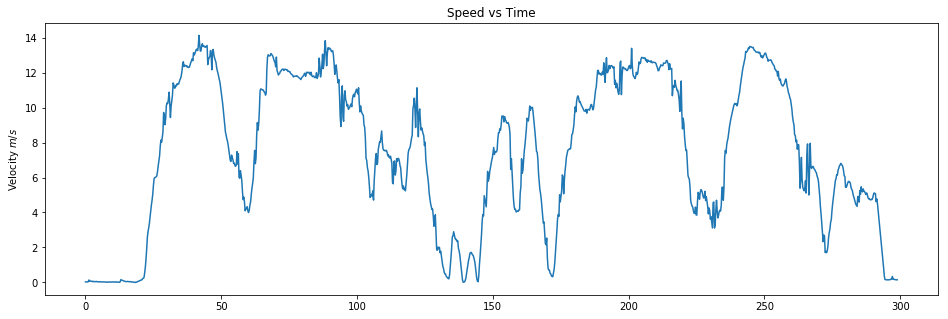

In [22]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(t_speedometer, speed[0])
    plt.ylabel(r'Velocity $m/s$')
    plt.title('Speed vs Time')

# Preprocessing

Now I am going to deal with both position and acceleration. The position gathered from the GNSS is recorded at 1 Hz (1 sample every second) while the acceleration in the IMU is at 100 Hz. So te first step will be to normalize both vector lengths (add 99 samples every period into the GNSS with copied data)

In [23]:
mpx = np.array(pos_ned[0, :])  # x position from GNSS
mpy = np.array(pos_ned[1, :])  # y position from GNSS

# Generate GPS Trigger
counter = len(t_imu[11:])

new_t_imu = t_imu[11:]
new_acc_imu = acc_imu[:,11:]
new_gyro_imu = gyro_imu[:,11:]

GPS = np.ndarray((counter), dtype='bool')
new_mpx = np.ndarray(counter)  # I want to start at 0.11 (same as the first GNSS signal)
new_mpy = np.ndarray(counter)

GPS[0] = True
new_mpx[0] = mpx[0]
new_mpy[0] = mpy[0]

# Less new position updates
for i in range(1,counter):
    if i % 100 == 0:
        GPS[i] = True
    else:
        new_mpx[i] = mpx[i // 100]
        new_mpy[i] = mpy[i // 100]
        GPS[i] = False

In [24]:
mx = new_acc_imu[0,:] # acceleration x axis
my = new_acc_imu[1,:] # acceleration y axis
measurements = np.vstack((new_mpx,new_mpy,mx,my)) # stack all of them in kind of a matrix
print(measurements.shape)

(4, 29838)


In [25]:
def plot_m():
    fig = plt.figure(figsize=(16,12))
    plt.subplots_adjust(hspace = 1)  
    plt.subplot(411)
    plt.step(range(counter),new_mpx, label='$x$')
    plt.ylabel(r'X Position $m$')
    plt.title('Measurements')
    plt.ylim([-100, 100])
    plt.legend(loc='best',prop={'size':18})

    plt.subplot(412)
    plt.step(range(counter),new_mpy, label='$y$')
    plt.ylabel(r'Y Position $m$')
    plt.title('Measurements')
    plt.ylim([-100, 100])
    plt.legend(loc='best',prop={'size':18})
    
    plt.subplot(413)
    plt.step(range(counter),mx, label='$y$')
    plt.ylabel(r'X Acceleration $m$')
    plt.title('Measurements')
    plt.ylim([-10, 10])
    plt.legend(loc='best',prop={'size':18})
    
    plt.subplot(414)
    plt.step(range(counter),my, label='$a_x$')
    plt.ylabel(r'Y Acceleration $m/s^2$')
    plt.ylim([-10, 10])
    plt.legend(loc='best',prop={'size':18})

    #plt.savefig('/img_notebook/Kalman-Filter-CA-Measurements.png', dpi=72, transparent=True, bbox_inches='tight')

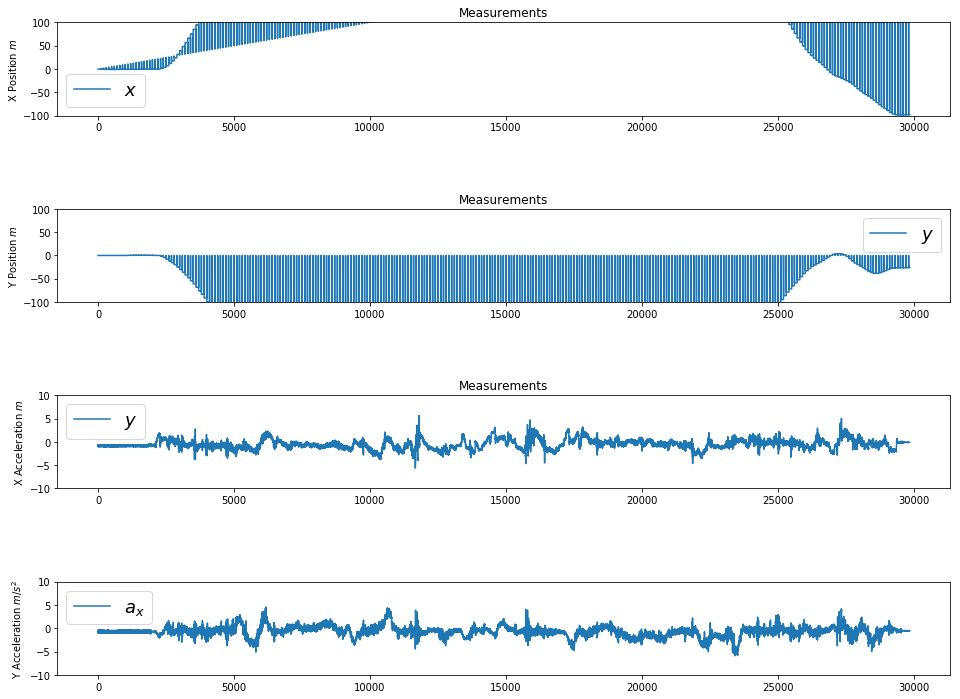

In [26]:
plot_m()

# Maths

### Definition

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta{t} & 0 & \frac{1}{2}\Delta t^{2} & 0 \\ 0 & 1 & 0 & \Delta t & 0 & \frac{1}{2} \Delta{t^{2}} \\ 0 & 0 & 1 & 0 & \Delta{t} & 0 \\ 0 & 0 & 0 & 1 & 0 & \Delta{t} \\ 0 & 0 & 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \\ \ddot{x} \\ \ddot{y}\end{bmatrix}_{k}$$

## Initialize matrices

### Initial state

$$x_k= \begin{matrix}x \\ y \\ \dot{x} \\ \dot{y} \\ \ddot{x} \\ \ddot{y}\end{matrix}$$

In [27]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T

### Initial Uncertainty

In [28]:
P = np.diag([100.0, 100.0, 10.0, 10.0, 1.0, 1.0]) # I assign more uncertainty to the position > velocity > acceleration

### Dynamic Matrix

In [29]:
dt = 0.01 # Time Step between Filter Steps (100 Hz)

A = np.matrix([[1.0, 0.0, dt, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 1.0, 0.0, dt, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 1.0, 0.0, dt, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

### Measurement Matrix

As I am just interested in the position (x,y) the H matrix will be:

$$y = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0\end{bmatrix} \cdot x$$

In [30]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])

### Measurement Noise Covariance

In [31]:
rp = 100.0**2  # Noise of Position Measurement
R = np.matrix([[rp, 0.0],
               [0.0, rp]])

### Process Noise Covariance

The forces acting on the car (i.e. wind). Right know I consider cte but NEEDS TO BE CHANGED

$$Q = \begin{bmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} & \sigma_{x \ddot x} & \sigma_{x \ddot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} & \sigma_{y \ddot x} & \sigma_{y \ddot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} & \sigma_{\dot x \ddot x} & \sigma_{\dot x \ddot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 & \sigma_{\dot y \ddot x} & \sigma_{\dot y \ddot y} \\ \sigma_{\ddot x x} & \sigma_{\ddot x y} & \sigma_{\ddot x \dot x} & \sigma_{\ddot x \dot y} & \sigma_{\ddot x}^2 & \sigma_{\ddot x \ddot y} \\ \sigma_{\ddot y x} & \sigma_{\ddot y y} & \sigma_{\ddot y \dot x} & \sigma_{\ddot y \dot y} & \sigma_{\ddot y \ddot x} & \sigma_{\ddot y}^2\end{bmatrix}$$

$$Q = G\cdot G^{T} \cdot \sigma_a^{2}$$

In [32]:
sa = 0.001 # standard deviation acceleration process noise
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [1.0],
               [1.0]])
Q = G*G.T*sa**2

# Kalman Filter

I will follow the convention of the picture:

![](img_notebook/Kalman-Filter-Step.png)

In [33]:
# Preallocation for Plotting
xt = []
yt = []
Zx = []
Zy = []
Px = []
Py = []
Kx = []
Ky = []

def savestates(x, Z, P, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))

In [34]:
I = np.eye(6)
for filterstep in range(counter):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # if there is a GPS Measurement
    if GPS[filterstep]:
        # Compute the Kalman Gain
        S = H*P*H.T + R
        K = (P*H.T) * np.linalg.pinv(S)
    
        
        # Update the estimate via z
        Z = measurements[:2,filterstep] # just get the data regarding the position  
        auxiliar_prod = H * x
        y = Z.T - auxiliar_prod[0,:]
        x = x + (K * y.T)

        # Update the error covariance
        P = (I - (K * H)) * P
  
    # Save states for Plotting
    savestates(x, Z, P, K)

In [36]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    #plt.subplot(211)
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})
    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.legend(loc='best',prop={'size':22})

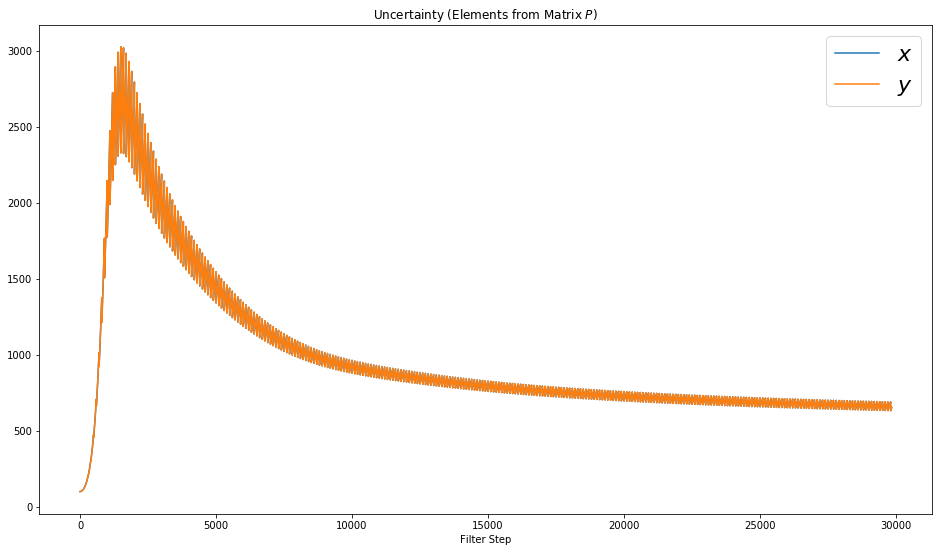

In [38]:
plot_P()